<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [3]:
!pip install watermark

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
# pip install watermark
%load_ext watermark

In [5]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.0
IPython 6.5.0

numpy 1.15.4
scipy 1.1.0
pandas 0.25.0
matplotlib 3.1.2
statsmodels 0.10.0
sklearn 0.0

compiler   : MSC v.1912 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   :


In [6]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [7]:
import sys
is_colab = 'google.colab' in sys.modules

if is_colab:
    from google.colab import drive
    drive.mount('/gdrive')
    %cd /gdrive

# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'
if is_colab:
    PATH_TO_DATA = '/gdrive/My Drive/Colab Notebooks/Stepik/6_reg/capstone_user_identification'    

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [8]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [9]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [11]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [12]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [15]:
# y_train = y_train.astype('int')
# X_train = X_train.astype('int')

In [16]:
cv_score = []
for train_index, test_index in skf.split(X_train, y_train):
    X_tr = X_train[train_index]
    y_tr = y_train[train_index]
    X_tst = X_train[test_index]
    y_tst = y_train[test_index]

    knn.fit(X_tr, y_tr)
    # prediction = knn.predict(X_tst)
    cv_score.append( accuracy_score(y_tst, knn.predict(X_tst)) )

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [17]:
round(np.array(cv_score).mean(), 3)

0.562

In [18]:
# y_train = y_train.astype('int')
knn.fit(X_train, y_train)
prediction = knn.predict(X_valid)

print(round(accuracy_score(y_valid, prediction), 3))

0.584


**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [21]:
forest.fit(X_train, y_train)
prediction = forest.predict(X_valid)

print(round(accuracy_score(y_valid, prediction), 3))

0.73


In [22]:
oob_score = []
for train_index, test_index in skf.split(X_train, y_train):
    X_tr = X_train[train_index]
    y_tr = y_train[train_index]
    X_tst = X_train[test_index]
    y_tst = y_train[test_index]

    forest.fit(X_tr, y_tr)
    # prediction = knn.predict(X_tst)
    oob_score.append(forest.oob_score_)

In [23]:
round(np.array(oob_score).mean(),3)

0.705

In [24]:
# write_answer_to_file(''' ВАШ КОД ЗДЕСЬ ''',
#                      'answer4_2.txt')

In [25]:
# !cat answer4_2.txt

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [26]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [27]:
logit = LogisticRegression(random_state=17, n_jobs=-1)

In [28]:
cv_score = []
for train_index, test_index in skf.split(X_train, y_train):
    X_tr = X_train[train_index]
    y_tr = y_train[train_index]
    X_tst = X_train[test_index]
    y_tst = y_train[test_index]

    logit.fit(X_tr, y_tr)
    # prediction = knn.predict(X_tst)
    cv_score.append( accuracy_score(y_tst, logit.predict(X_tst)) )

In [29]:
round(np.array(cv_score).mean(), 3)

0.763

In [30]:
logit.fit(X_train, y_train)
prediction = logit.predict(X_valid)

print(round(accuracy_score(y_valid, prediction), 3))

0.782


## LogisticRegressionCV

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [31]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv=skf, multi_class='multinomial', random_state=17, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 11 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [32]:
logit_mean_cv_scores1 = np.max(logit_grid_searcher1.scores_[31], axis=0) 

In [33]:
print(logit_mean_cv_scores1)

[0.32724505 0.47925564 0.55643685 0.65812748 0.71759683 0.75472849
 0.76388041 0.76540574 0.75625381 0.75167785]


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [34]:
logit_grid_searcher1.scores_[31].max()

0.7654057352043929

In [35]:
#logit_grid_searcher1.scores_[31]

best_c_index = np.argmax(logit_grid_searcher1.scores_[31], axis=1)[0]
logit_c_values1[best_c_index]

4.641588833612772

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

In [36]:
logit_mean_cv_scores1

array([0.32724505, 0.47925564, 0.55643685, 0.65812748, 0.71759683,
       0.75472849, 0.76388041, 0.76540574, 0.75625381, 0.75167785])

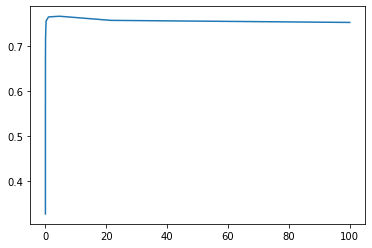

In [37]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [38]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf, multi_class='multinomial', random_state=17, n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 26.2 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [39]:
logit_mean_cv_scores2 = np.max(logit_grid_searcher2.scores_[31], axis=0) 
print(logit_mean_cv_scores2)

[0.73703478 0.76327029 0.76296522 0.76418548 0.76540574 0.76499239
 0.76468798 0.76377473 0.76468798 0.76418548 0.76499239 0.76377473
 0.76407915 0.76347032 0.76316591 0.76174497 0.76174497 0.76120769
 0.76090271 0.76059774]


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [40]:
logit_grid_searcher2.scores_[31].max()

0.7654057352043929

In [41]:
best_c_index2 = np.argmax(logit_grid_searcher2.scores_[31], axis=1)[0]
logit_c_values2[best_c_index2]

1.9157894736842107

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

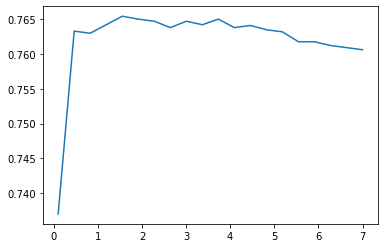

In [42]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

In [43]:
logit_c_values1[best_c_index] > logit_c_values2[best_c_index2]

True

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [44]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher1.predict(X_valid))

In [45]:
logit_cv_acc

0.7788575491822707

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [46]:
cv_score = []
for train_index, test_index in skf.split(X_train, y_train):
    X_tr = X_train[train_index]
    y_tr = y_train[train_index]
    X_tst = X_train[test_index]
    y_tst = y_train[test_index]

    #logit_grid_searcher2.fit(X_tr, y_tr)
    # prediction = knn.predict(X_tst)
    cv_score.append( accuracy_score(y_tst, logit_grid_searcher2.predict(X_tst)) )
    
print(round(np.array(cv_score).mean(), 3))

0.885


In [47]:
round(accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid)), 3)

0.779

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [48]:
from sklearn.svm import LinearSVC

In [49]:
svm = LinearSVC(C=1., random_state=17)

In [50]:
cv_score = []
for train_index, test_index in skf.split(X_train, y_train):
    X_tr = X_train[train_index]
    y_tr = y_train[train_index]
    X_tst = X_train[test_index]
    y_tst = y_train[test_index]

    svm.fit(X_tr, y_tr)
    # prediction = knn.predict(X_tst)
    cv_score.append( accuracy_score(y_tst, svm.predict(X_tst)) )
    
print(round(np.array(cv_score).mean(), 3))

0.757


In [51]:
round(accuracy_score(y_valid, svm.predict(X_valid)), 3)

0.757

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [52]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(LinearSVC(random_state=17), param_grid=svm_params1, n_jobs=-1, cv=skf, return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 19.2 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [53]:
svm_grid_searcher1.best_score_

0.6890875838244259

In [54]:
svm_grid_searcher1.best_estimator_

LinearSVC(C=1111.1112, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
          verbose=0)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

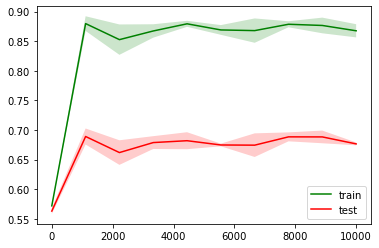

In [55]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [56]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(LinearSVC(random_state=17), param_grid=svm_params2, n_jobs=-1, cv=skf, return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 28.1 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [57]:
svm_grid_searcher2.best_score_

0.7649867913025807

In [58]:
svm_grid_searcher2.best_estimator_

LinearSVC(C=0.24213793103448275, class_weight=None, dual=True,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=1000, multi_class='ovr', penalty='l2', random_state=17,
          tol=0.0001, verbose=0)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

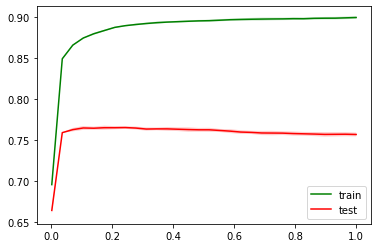

In [59]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [60]:
svm_grid_searcher2.best_estimator_.predict(X_valid)

array([ 33, 128,  39, ..., 207,  39, 237], dtype=int64)

In [61]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.predict(X_valid))
print(round(svm_cv_acc,3))

0.784


**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [62]:
cv_score = []
for train_index, test_index in skf.split(X_train, y_train):
    X_tr = X_train[train_index]
    y_tr = y_train[train_index]
    X_tst = X_train[test_index]
    y_tst = y_train[test_index]

    svm_grid_searcher2.best_estimator_.fit(X_tr, y_tr)
    # prediction = knn.predict(X_tst)
        
    cv_score.append( accuracy_score(y_tst, svm_grid_searcher2.best_estimator_.predict(X_tst)) )
    # cv_score.append(svm_grid_searcher2.best_estimator_.score(X_tst, y_tst))
    
print(round(np.array(cv_score).mean(), 3))

0.765


In [63]:
svm_grid_searcher2.best_estimator_.fit(X_train, y_train)

round(accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.predict(X_valid)), 3)

0.784

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [64]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''

    with open(path_to_X_pickle, 'rb') as handler:
        X_sparse = pickle.load(handler)    
    with open(path_to_y_pickle, 'rb') as handler:
        y = pickle.load(handler)
        
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, np.array(y), test_size=test_size, 
                                                          random_state=random_state, stratify=y)
        
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    
    cv_score = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr = X_train[train_index]
        y_tr = y_train[train_index]
        X_tst = X_train[test_index]
        y_tst = y_train[test_index]
        
        estimator.fit(X_tr, y_tr)
        cv_score.append(accuracy_score(y_tst, estimator.predict(X_tst)))

    mean_cv_score = round(np.array(cv_score).mean(),3)
    
    
    estimator.fit(X_train, y_train)
    score_vaild = round(accuracy_score(y_valid, estimator.predict(X_valid)), 3)
    
    return mean_cv_score, score_vaild                                 

**Убедитесь, что функция работает.**

In [65]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.765, 0.784)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [66]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [67]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        # X_sparse_10users_s10_w5.pkl
        path_to_X_pkl = 'X_sparse_10users_s{0}_w{1}.pkl'.format(session_length, window_size)
        path_to_y_pkl = 'y_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size)
        
#         if not os.path.isfile(path_to_X_pkl):
#             print(path_to_X_pkl)
#         if not os.path.isfile(path_to_y_pkl):
#             print(path_to_y_pkl)
        
        print('window_size: ' + str(window_size) + ' session_lenght: ' + str(session_length))
        print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, cv=skf))
        print('---')
        #break

window_size: 10 session_lenght: 15
(0.824, 0.842)
---
window_size: 10 session_lenght: 10
(0.765, 0.784)
---
window_size: 7 session_lenght: 15
(0.85, 0.856)
---
window_size: 7 session_lenght: 10
(0.8, 0.807)
---
window_size: 7 session_lenght: 7
(0.752, 0.763)
---
window_size: 5 session_lenght: 15
(0.872, 0.877)
---
window_size: 5 session_lenght: 10
(0.818, 0.829)
---
window_size: 5 session_lenght: 7
(0.773, 0.788)
---
window_size: 5 session_lenght: 5
(0.725, 0.738)
---
Wall time: 55.5 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [68]:
svm5 = LinearSVC(C=svm_grid_searcher2.best_estimator_.get_params()['C'], random_state=17)

In [69]:
path_to_X_pkl = 'X_sparse_10users_s15_w5.pkl'
path_to_y_pkl = 'y_sparse_10users_s15_w5.pkl'

model_assessment(svm5, path_to_X_pkl, path_to_y_pkl, skf)

(0.872, 0.877)

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [70]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:    
    path_to_X_pkl = 'X_sparse_10users_s{0}_w{1}.pkl'.format(session_length, window_size)
    path_to_y_pkl = 'y_sparse_10users_s{0}_w{1}.pkl'.format(session_length, window_size)
    print           ''' ВАШ КОД ЗДЕСЬ '''

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(''' ВАШ КОД ЗДЕСЬ ''')? (<unknown>, line 6)

**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [72]:
path_to_X_pkl = 'X_sparse_150users.pkl'
path_to_y_pkl = 'y_150users.pkl'

model_assessment(svm_grid_searcher2.best_estimator_, path_to_X_pkl, path_to_y_pkl, skf)

(0.46, 0.484)

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [73]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [74]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [78]:
logit_c_values1[best_c_index]

numpy.float64

In [118]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_c_values2[best_c_index2]], multi_class='ovr', 
                                         random_state=17, n_jobs=-1, cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 4min 57s


In [127]:
%%time

# Alternate
logit_c_values1 = np.logspace(-4, 2, 10)
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_cv_150users = LogisticRegressionCV(Cs=logit_c_values2, multi_class='ovr', 
                                         random_state=17, n_jobs=-1, cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 29min 6s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [128]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = logit_cv_150users.scores_[user_id].mean()
    print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id]))
    

User 6, CV score: 0.9960204504513475
User 13, CV score: 0.9963451898379284
User 15, CV score: 0.9951805055892229
User 16, CV score: 0.991912118844098
User 28, CV score: 0.9902743062775414
User 31, CV score: 0.9942963127726737
User 33, CV score: 0.9935738155800696
User 39, CV score: 0.9859492431689215
User 46, CV score: 0.997914948061116
User 49, CV score: 0.9951475001212499
User 50, CV score: 0.9942827364362543
User 53, CV score: 0.9935447792823776
User 65, CV score: 0.9969378419639349
User 66, CV score: 0.9947247019402946
User 82, CV score: 0.9962519057638384
User 85, CV score: 0.9963336127665178
User 89, CV score: 0.9904675927417678
User 92, CV score: 0.9943677162758847
User 100, CV score: 0.9945586133451597
User 102, CV score: 0.9914211923364428
User 103, CV score: 0.9808521785282968
User 105, CV score: 0.9969159882552946
User 106, CV score: 0.9947180730339933
User 118, CV score: 0.9910081231620421
User 119, CV score: 0.996662765867749
User 120, CV score: 0.9942208908566161
User 126

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [133]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = []

for user_id in np.unique(y_train_150):
    acc_diff_vs_constant.append(cv_scores_by_user[user_id] - 
                                (class_distr.sum() - class_distr[user_id])/class_distr.sum())
    

In [134]:
# num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default = (np.array(list(acc_diff_vs_constant)) > 0).sum()

In [135]:
num_better_than_default / np.unique(y_train_150).shape[0]

0.8133333333333334

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [150]:
y_binary_128 = [1 if x==128 else 0 for x in y_150users]

In [152]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [167]:
np.unique(np.array(y_binary_128))

array([0, 1])

In [168]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X=X_sparse_150users, y=y_binary_128, train_sizes=train_sizes, cv=skf)

Wall time: 34.1 s


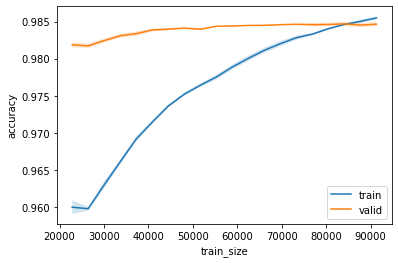

In [169]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.